In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns

from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import MinMaxScaler


df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet')
df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet')
df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet')
df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet')
df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet').fillna(0)

In [3]:
# Define the data generator function
def data_generator(data, window_size, batch_size, indices, test=False, shap=False):
    while True:
        global batch_data
        global input_sequences
        batch_data = []
        batch_targets = []
        for index in indices:
            dt_index = df_1T.iloc[index].name

            input_sequences = np.array([

            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-360:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-360:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-360:].fillna(0).values.astype('float32')

            ])

            # Extract the target high and low values
            target_high = df_1T[index : index+151].high_es.max()
            target_low = df_1T[index : index+151].low_es.min()

            # Add the input sequence and targets to the batch
            batch_data.append(input_sequences)
            batch_targets.append([target_high, target_low])
            #print(f'batch_data shape: {len(batch_data), batch_data[-1].shape}')

            #print([target_high, target_low], index)
            if len(batch_data) == batch_size:
                
                # Convert to np.array
                batch_data = np.asarray(batch_data)
                batch_targets = np.asarray(batch_targets)
                #print(f'final batch shape {batch_data.shape, type(batch_data[0])}')
                #sys.exit()
                # Normalize
                for i in range(batch_data.shape[1]):
                    a = batch_data[:, i, :, :]
                    scaler = MinMaxScaler()
                    batch_data[:, i, :, :] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])
                
                batch_data = batch_data.astype('float32')
                batch_data = np.split(batch_data, 6, axis=1)
                batch_data = [element.squeeze(axis=1) for element in batch_data]
                
                if test:
                    yield batch_data, np.asarray(batch_targets).astype('float32')
                elif shap:
                    yield tf.convert_to_tensor(np.asarray(batch_data), np.asarray(batch_targets).astype('float32'))
                else:
                    yield batch_data, np.asarray(batch_targets).astype('float32')
                batch_data = []
                batch_targets = []
                
        # Yield the remaining batch if it doesn't equal the batch size
        if batch_data:
         # Convert to np.array
            batch_data = np.asarray(batch_data)
            batch_targets = np.asarray(batch_targets)
            
            # Normalize
            for i in range(batch_data.shape[1]):
                a = batch_data[:, i, :, :]
                scaler = MinMaxScaler()
                batch_data[:, i, :, :] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])
            
            batch_data = batch_data.astype('float32')
            batch_data = np.split(batch_data, 6, axis=1)
            batch_data = [element.squeeze(axis=1) for element in batch_data]
            
            if test:
                yield batch_data, np.asarray(batch_targets).astype('float32')
            elif shap:
                yield tf.convert_to_tensor(np.asarray(batch_data), np.asarray(batch_targets))
            else:
                yield batch_data, np.asarray(batch_targets).astype('float32')
        batch_data = []
        batch_targets = []

# Set the window size and batch size
window_size = 362880 # minutes in 252 days (1 year of trading days)
batch_size = 32
num_features = 27

# Set the split ratios
train_ratio = 0.8
val_ratio = 0.1

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > 712853)]['index'].to_numpy()
np.random.shuffle(indices)
train_size = int(len(indices) * train_ratio)
val_size = int(len(indices) * val_ratio)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

#get the mean and std for normalization
#price_cols_to_normalize = list(set(df_dropped.columns[(df_dropped>1).any()]) - set(['weekly_open', 'weekly_close', 'daily_open']))

# Create the data generators for training, validation, and testing
train_generator = data_generator(df_1T, window_size, batch_size, train_indices)
val_generator = data_generator(df_1T, window_size, batch_size, val_indices)
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_indices) // batch_size
val_steps = len(val_indices) // batch_size

In [23]:
x, _ = next(train_generator)

In [9]:
# Define the Transformer model

# Set the window size and number of features

# Define the input layer
inputs_1T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_5T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_15T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_4H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1B = Input(shape=(360, num_features), batch_size=batch_size)

main_inputs = [inputs_1T, inputs_5T, inputs_15T, inputs_1H, inputs_4H, inputs_1B]

# Apply batch normalization to each input
inputs_1T_norm = BatchNormalization()(inputs_1T)
inputs_5T_norm = BatchNormalization()(inputs_5T)
inputs_15T_norm = BatchNormalization()(inputs_15T)
inputs_1H_norm = BatchNormalization()(inputs_1H)
inputs_4H_norm = BatchNormalization()(inputs_4H)
inputs_1B_norm = BatchNormalization()(inputs_1B)

inputs = [inputs_1T_norm, inputs_5T_norm, inputs_15T_norm, inputs_1H_norm, inputs_4H_norm, inputs_1B_norm]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inputs in zip(timeframes, inputs):
    conv_layer = Conv1D(filters=32, kernel_size=num_features, strides=1, activation='relu')(inputs)
    conv_layer = BatchNormalization()(conv_layer)
    conv_layer = Dropout(0.5)(conv_layer)

    # Add LSTM layers
    x = LSTM(32, return_sequences=True)(conv_layer)
    x = Dropout(0.5)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    
    # Add transformer layers
    x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x)
    #x = Dropout(0.5)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = TimeDistributed(Dense(32, activation='relu'))(x)
    x = Dropout(0.5)(x)
    conv_outputs.append(x)
    
# Concatenate the output
conv_output = Concatenate(axis=1)(conv_outputs)

# Reshape the output to have a 3D shape
#conv_output = Reshape((-1, len(timeframes) * 32))(conv_output)

# Define the output layer
output1 = TimeDistributed(Dense(1), name='output1')(conv_output)
output2 = TimeDistributed(Dense(1), name='output2')(conv_output)
output1 = GlobalAveragePooling1D()(output1)
output2 = GlobalAveragePooling1D()(output2)
outputs = [output1, output2]
output = Concatenate()([output1, output2])
output = Dense(2)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'], run_eagerly=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(32, 360, 27)]      0           []                               
                                                                                                  
 input_14 (InputLayer)          [(32, 360, 27)]      0           []                               
                                                                                                  
 input_15 (InputLayer)          [(32, 360, 27)]      0           []                               
                                                                                                  
 input_16 (InputLayer)          [(32, 360, 27)]      0           []                               
                                                                                            

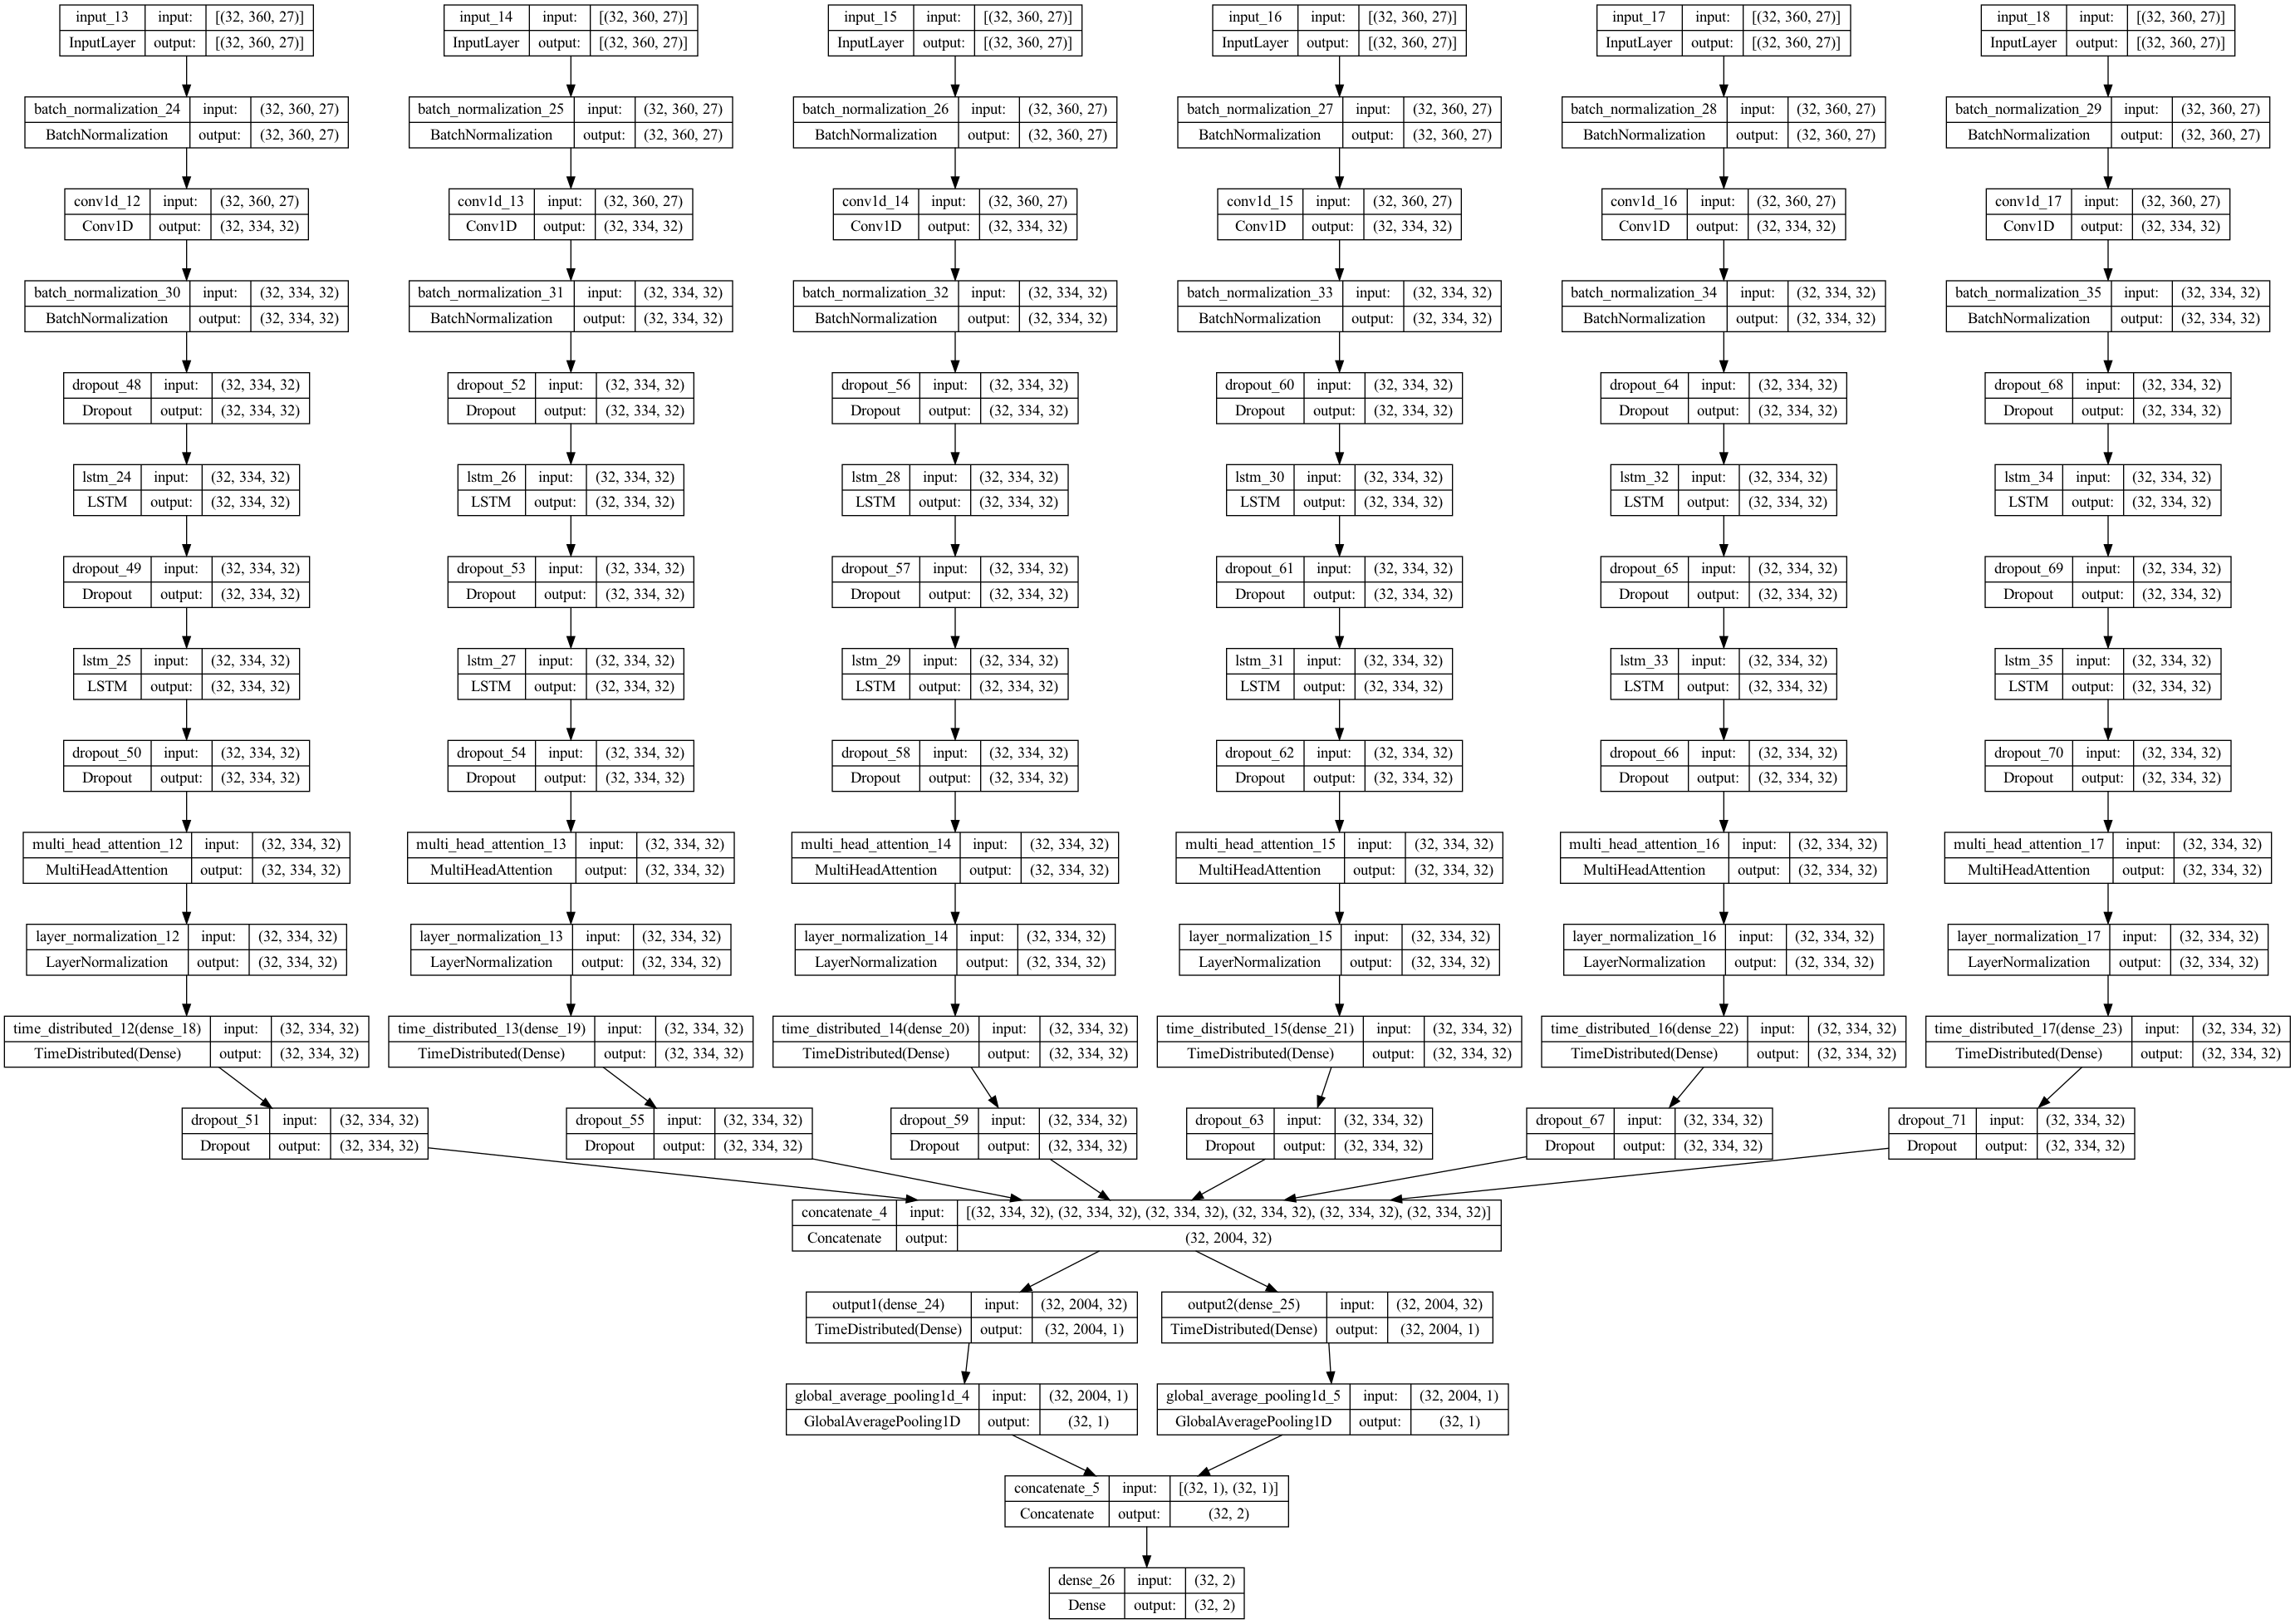

In [10]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# We dropped the na rows for the dataset, since during data generation, it would also includ the weekend timepoints.
# We need to pad to the maximum possible values for each timeframe and lookback
# for example 1T for 1 day will have max 1440 values
# 5T for 2 days will have max 1440*2/5 values (.....or it should!)

Epoch 1/30
115/115 [==============================] - 118s 923ms/step - loss: 697.5086 - mae: 16.7192 - val_loss: 251.2425 - val_mae: 14.0393
Epoch 2/30
115/115 [==============================] - 84s 726ms/step - loss: 78.4609 - mae: 5.8987 - val_loss: 143.2971 - val_mae: 8.8799
Epoch 3/30
115/115 [==============================] - 82s 710ms/step - loss: 66.7820 - mae: 5.4260 - val_loss: 69.3031 - val_mae: 6.6976
Epoch 4/30
115/115 [==============================] - 80s 694ms/step - loss: 62.3175 - mae: 5.0525 - val_loss: 58.2404 - val_mae: 5.8979
Epoch 5/30
115/115 [==============================] - 87s 758ms/step - loss: 62.1877 - mae: 5.1336 - val_loss: 64.2590 - val_mae: 6.4337
Epoch 6/30
115/115 [==============================] - 84s 726ms/step - loss: 55.0856 - mae: 4.7679 - val_loss: 76.0933 - val_mae: 6.7073
Epoch 7/30
115/115 [==============================] - 81s 705ms/step - loss: 60.9500 - mae: 5.1674 - val_loss: 59.3445 - val_mae: 6.1974
Epoch 8/30
115/115 [===============

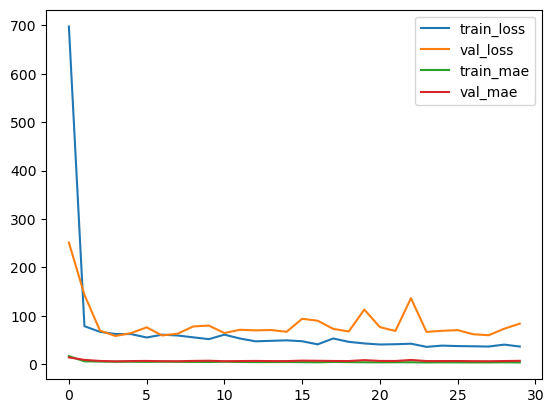

In [11]:
epochs = 30
lr = 1e-2
lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)

history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=epochs,
          validation_data=val_generator, validation_steps=val_steps, callbacks=[lr_schedule])

# Plot the training and validation loss and MAE
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.show()

In [72]:
model.inputs

[<KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_14')>,
 <KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_15')>,
 <KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_16')>,
 <KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_17')>,
 <KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_18')>,
 <KerasTensor: shape=(8, 360, 27) dtype=float32 (created by layer 'input_19')>]

In [140]:
batch_data = []
batch_targets = []
index = train_indices[10]
dt_index = df_1T.iloc[index].name

input_sequences = [

df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-360:].drop(columns='index').values,
df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-360:].values,
df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-360:].values,
df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].values,
df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].values,
df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-360:].values

]

# Extract the target high and low values
target_high = df_1T[index : index+151].high_es.max()
target_low = df_1T[index : index+151].low_es.min()

# Add the input sequence and targets to the batch
batch_data.append(input_sequences)
batch_targets.append([target_high, target_low])

In [81]:
x,y = next(train_generator)

<Axes: xlabel='datetime'>

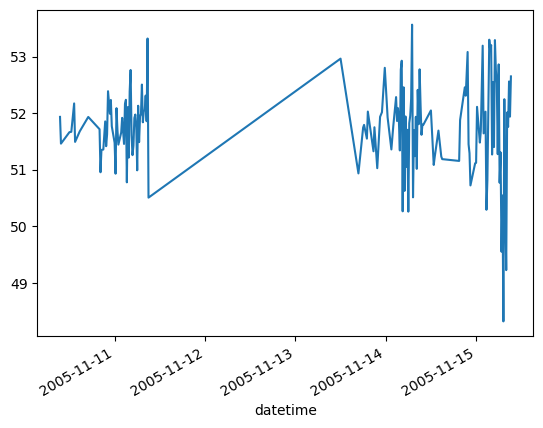

In [143]:
df_15T[dt_index - pd.tseries.offsets.BusinessDay(3) : dt_index - pd.Timedelta(minutes=1)].open_es.plot()

In [ ]:
Epoch 10/10
18/18 [==============================] - 146s 8s/step - loss: 1.8419e-04 - mae: 0.0107 - val_loss: 8.4897e-05 - val_mae: 0.0076

Epoch 3/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x)
144/144 [==============================] - 24s 165ms/step - loss: 8.0584e-04 - mae: 0.0217 - val_loss: 3.0579e-05 - val_mae: 0.0041

Epoch 18/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 33s 233ms/step - loss: 3.2141e-05 - mae: 0.0039 - val_loss: 1.5543e-05 - val_mae: 0.0025

Epoch 5/30
144/144 [==============================] - 33s 230ms/step - loss: 2.5526e-04 - mae: 0.0129 - val_loss: 2.5898e-05 - val_mae: 0.0039

Epoch 11/30 - tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 79s 546ms/step - loss: 4.5514e-05 - mae: 0.0047 - val_loss: 1.5869e-05 - val_mae: 0.0026


Epoch 21/30 - tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x) - batchnorm after inputs
144/144 [==============================] - 38s 262ms/step - loss: 2.1482e-05 - mae: 0.0028 - val_loss: 1.6468e-05 - val_mae: 0.0024

Epoch 18/30 - same as above but both LSTMs are 32
140/140 [==============================] - 83s 593ms/step - loss: 2.0085e-05 - mae: 0.0028 - val_loss: 1.9584e-05 - val_mae: 0.0028

In [34]:
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_steps)
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices)
model.evaluate(test_generator, steps=test_steps)

#dates = df.iloc[test_indices].index.strftime("%Y-%m-%d")[:576]

# Extract the predicted high and low values
predicted_high = predictions[:, 0]
predicted_low = predictions[:, 1]

# Reset the test data generator to get actual values
test_generator = data_generator(df_dropped, window_size, batch_size, test_indices, test=True)

# Get the actual high and low values
actual_high = []
actual_low = []
dates = []
open_prices = []
x_test = []
for i in range(test_steps):
    x, batch_targets, op, d = next(test_generator)
    x_test.append(x)
    actual_high.extend(batch_targets[:, 0])
    actual_low.extend(batch_targets[:, 1])
    dates.extend(d)
    open_prices.extend(op)
    
    
actual_high = np.exp(actual_high) * open_prices
actual_low = np.exp(actual_low) * open_prices
predicted_high = np.exp(predicted_high) * open_prices
predicted_low = np.exp(predicted_low) * open_prices

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


17/17 [==============================] - 14s 845ms/step - loss: 2.3801e-05 - mae: 0.0027


In [58]:
model.save_weights('./checkpoints/CNN-LSTM')

In [8]:
x,y = next(train_generator)

/Users/kush/Documents/DS/env/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
x

array([[[0.89917886, 0.8699387 , 0.9294414 , ..., 0.20680843,
         0.        , 0.37834898],
        [0.90142953, 0.8721004 , 0.93286556, ..., 0.20680843,
         0.        , 0.37834898],
        [0.90367854, 0.8731811 , 0.9351482 , ..., 0.20680843,
         0.        , 0.37834898],
        ...,
        [0.30313915, 0.29715768, 0.3271747 , ..., 0.20680843,
         0.        , 0.37834898],
        [0.30669555, 0.2948774 , 0.323565  , ..., 0.20680843,
         0.        , 0.37834898],
        [0.30551022, 0.29373777, 0.31754592, ..., 0.20680843,
         0.        , 0.37834898]],

       [[0.10094811, 0.09705821, 0.12047681, ..., 0.20680843,
         0.        , 0.37834898],
        [0.099351  , 0.09552263, 0.12047681, ..., 0.20680843,
         0.        , 0.37834898],
        [0.099351  , 0.09552263, 0.12047681, ..., 0.20680843,
         0.        , 0.37834898],
        ...,
        [0.29720667, 0.2887706 , 0.316382  , ..., 0.20680843,
         0.        , 0.37834898],
        [0.2

In [23]:
res = pd.DataFrame(np.array([predicted_high.round(2), actual_high.round(2), abs(predicted_high - actual_high).round(2),  predicted_low.round(2), actual_low.round(2), abs(predicted_low - actual_low)]).T.round(2), columns=['p_high', 'a_high','mae_high', 'p_low', 'a_low', 'mae_low'], index=dates)
res.index = pd.to_datetime(res.index)

In [48]:
np.array(x_test).shape

(544, 4320, 72)

In [30]:
# Plot the predictions against each input feature
for i in range(num_features):
    plt.figure()
    plt.scatter(test_data[:, :, i].flatten(), test_pred[:, 0].flatten())
    plt.xlabel(f'Feature {i+1}')
    plt.ylabel('Predicted Value')
    plt.title(f'Predictions vs Feature {i+1}')

NameError: name 'X_test' is not defined

In [50]:
res[(res.mae_high <= 1) & (res.mae_low <= 1)]

,p_high,a_high,mae_high,p_low,a_low,mae_low
2002-04-15,1109.390015,1109.00,0.39,1102.839966,1102.50,0.34
2003-06-26,986.109985,985.50,0.61,980.289978,981.25,0.96
2012-09-28,1438.069946,1437.50,0.57,1428.750000,1428.75,0.00
2002-05-21,1084.790039,1084.00,0.79,1078.349976,1079.25,0.90
2001-10-23,1089.160034,1090.00,0.84,1082.400024,1081.50,0.90
2001-05-08,1266.660034,1266.25,0.41,1258.680054,1258.00,0.68
